In [1]:
import pandas as pd
import numpy as np
import pywt 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import numpy as np
import pywt
from numba import jit

# Introduction

https://github.com/borisbanushev/stockpredictionai/issues/19#issuecomment-468768604

There's a clear lookahead bias problem (described in the link) with a simple implementation of wavelet decomposition and reconstruction using pywt.  The correct approach is to denoise a feature with only historical data.

## Dabauchies

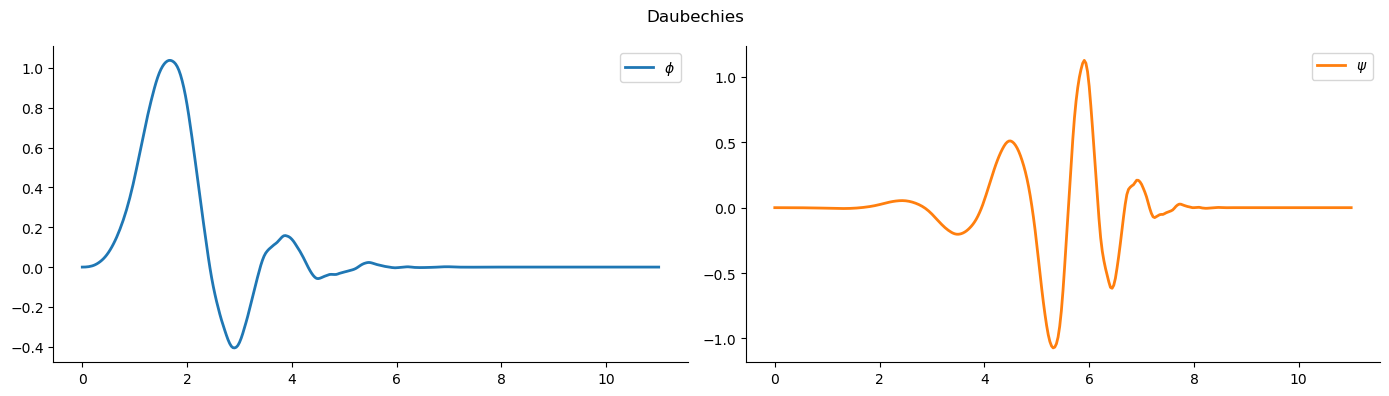

In [2]:
wavelet = pywt.Wavelet('db6')
phi, psi, x = wavelet.wavefun(level=5)
df = pd.DataFrame({'$\phi$': phi, '$\psi$': psi}, index=x)
df.plot(title='Daubechies', subplots=True, layout=(1, 2), figsize=(14, 4), lw=2, rot=0)
plt.tight_layout()
sns.despine();

In [3]:
# plot_data = [('db', (4, 3)),
#              ('sym', (4, 3)),
#              ('coif', (3, 2))]


# for family, (rows, cols) in plot_data:
#     fig = plt.figure(figsize=(24, 12))
#     fig.subplots_adjust(hspace=0.2, wspace=0.2, bottom=.02, left=.06,
#                         right=.97, top=.94)
#     colors = itertools.cycle('bgrcmyk')

#     wnames = pywt.wavelist(family)
#     i = iter(wnames)
#     for col in range(cols):
#         for row in range(rows):
#             try:
#                 wavelet = pywt.Wavelet(next(i))
#             except StopIteration:
#                 break
#             phi, psi, x = wavelet.wavefun(level=5)

#             color = next(colors)
#             ax = fig.add_subplot(rows, 2 * cols, 1 + 2 * (col + row * cols))
#             ax.set_title(wavelet.name + " phi")
#             ax.plot(x, phi, color, lw=1)
#             ax.set_xlim(min(x), max(x))

#             ax = fig.add_subplot(rows, 2*cols, 1 + 2*(col + row*cols) + 1)
#             ax.set_title(wavelet.name + " psi")
#             ax.plot(x, psi, color, lw=1)
#             ax.set_xlim(min(x), max(x))
#     sns.despine()

# for family, (rows, cols) in [('bior', (4, 3)), ('rbio', (4, 3))]:
#     fig = plt.figure(figsize=(24, 12))
#     fig.subplots_adjust(hspace=0.5, wspace=0.2, bottom=.02, left=.06,
#                         right=.97, top=.94)

#     colors = itertools.cycle('bgrcmyk')
#     wnames = pywt.wavelist(family)
#     i = iter(wnames)
#     for col in range(cols):
#         for row in range(rows):
#             try:
#                 wavelet = pywt.Wavelet(next(i))
#             except StopIteration:
#                 break
#             phi, psi, phi_r, psi_r, x = wavelet.wavefun(level=5)
#             row *= 2

#             color = next(colors)
#             ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
#             ax.set_title(wavelet.name + " phi")
#             ax.plot(x, phi, color, lw=1)
#             ax.set_xlim(min(x), max(x))

#             ax = fig.add_subplot(2*rows, 2*cols, 2*(1 + col + row*cols))
#             ax.set_title(wavelet.name + " psi")
#             ax.plot(x, psi, color, lw=1)
#             ax.set_xlim(min(x), max(x))

#             row += 1
#             ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
#             ax.set_title(wavelet.name + " phi_r")
#             ax.plot(x, phi_r, color, lw=1)
#             ax.set_xlim(min(x), max(x))

#             ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols) + 1)
#             ax.set_title(wavelet.name + " psi_r")
#             ax.plot(x, psi_r, color, lw=1)
#             ax.set_xlim(min(x), max(x))
#     sns.despine()

# plt.show()

In [4]:
df = pd.read_csv('train_files/wavelet_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(['Code', 'Date'], inplace=True)

In [5]:
# # function copied here for viewing convenience
# def wavelet_smooth(signal: pd.Series, threshold=0.2, level=3, wavelet='db6', mode='reflect'):
#     signal = signal.dropna()
#     coeff = pywt.wavedec(signal, wavelet, mode=mode, level=level)
#     coeff[1:] = [pywt.threshold(i, value=threshold*np.abs(signal.max()), mode='soft') for i in coeff[1:]]
    
#     clean_signal = pywt.waverec(coeff, wavelet, mode=mode)
#     clean_signal = clean_signal[:len(signal)]
    
#     return pd.Series(clean_signal, index=signal.index)

# Xt = df.loc[6407, 'delta_beta_diff1'].dropna().copy()

# level = 2
# threshold = 0.3
# coeffs = pywt.wavedec(Xt, wavelet='db6', level=level, mode='symmetric')
# cA, cD_list = coeffs[0], coeffs[1::]

# thresholded_coeffs = [cA] + [pywt.threshold(cD, value=threshold, mode='soft') for cD in cD_list]

# Y_t = pywt.waverec(thresholded_coeffs, wavelet='db6', mode='symmetric')


# fig, ax = plt.subplots()

# ax.plot(Xt.index, Xt)
# ax.plot(Xt.index, Y_t)

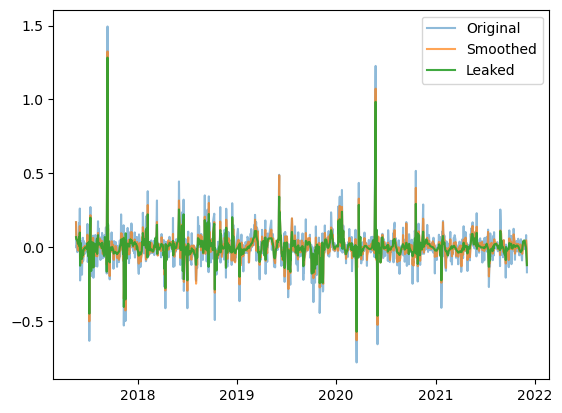

In [71]:
def wavelet_smooth(signal: pd.Series, wavelet='db6', level=2, threshold=0.3, decomp_mode='symmetric', thresh_mode='soft'):
    signal = signal.dropna()
    coeffs = pywt.wavedec(signal, wavelet, mode=decomp_mode, level=level)
    cA, cD_list = coeffs[0], coeffs[1:]
    thresholded_coeffs = [cA] + [
        pywt.threshold(cD, value=threshold, mode=thresh_mode) for cD in cD_list
    ]    
    clean_signal = pywt.waverec(thresholded_coeffs, wavelet, mode=decomp_mode)
    clean_signal = clean_signal[:len(signal)]
    
    return pd.Series(clean_signal, index=signal.index)

def wavelet_smoothing_causal(signal:pd.Series, wavelet='db6', level=2, threshold=0.3, decomp_mode='symmetric', thresh_mode='soft'):
    """
    Perform wavelet smoothing on a signal using all historical data up to the current time step (causal approach).
    Args:
        signal (pd.Series): Input signal to smooth.
        wavelet (str): Wavelet type (default is 'db6').
        level (int): Number of decomposition levels.
        threshold (float): Threshold value for denoising.
    Returns:
        np.ndarray: Smoothed signal.
    """
    smoothed_signal = np.zeros_like(signal)  # Placeholder for smoothed values
    
    for t in range(1, len(signal) + 1):
        # Use all historical data up to current time step t
        historical_data = signal[:t]
        
        # Perform wavelet decomposition
        coeffs = pywt.wavedec(historical_data, wavelet=wavelet, level=level, mode=decomp_mode)
        cA, cD_list = coeffs[0], coeffs[1:]
        
        # Apply thresholding to detail coefficients
        thresholded_coeffs = [cA] + [
            pywt.threshold(cD, value=threshold, mode=thresh_mode) for cD in cD_list
        ]
        
        # Reconstruct signal from thresholded coefficients
        smoothed_historical = pywt.waverec(thresholded_coeffs, wavelet=wavelet, mode=decomp_mode)
        
        # Assign the last value of the smoothed result to the current time step
        smoothed_signal[t - 1] = smoothed_historical[-1]
    smoothed_series = pd.Series(smoothed_signal, index=signal.index)
    return smoothed_series

Xt = df.loc[6407, 'delta_beta_diff1'].dropna()  # Replace with your data
wave = 'db6'
wavelet = pywt.Wavelet(wave)
level = 3
threshold = 0.1

Yt = wavelet_smoothing_causal(Xt, wave, level=level, threshold=threshold)
Yt_leaked = wavelet_smooth(Xt, wave, level, threshold)

fig, ax = plt.subplots()
ax.plot(Xt, label="Original", alpha = 0.5)
ax.plot(Yt, label="Smoothed", alpha=0.7)
ax.plot(Yt_leaked, label="Leaked", alpha=0.9)
ax.legend()
plt.show()


In [ ]:
# CONVOVLE APPROACH 

@jit(nopython=True)
def threshold_coefficients(coeffs, threshold):
    """
    Apply soft thresholding to wavelet coefficients.
    """
    return np.sign(coeffs) * np.maximum(np.abs(coeffs) - threshold, 0)

def wavelet_smoothing_causal_numba(signal, wavelet='db6', level=2, threshold=0.3):
    """
    Perform wavelet smoothing on a signal using all historical data up to the current time step (causal approach).
    Optimized with Numba for faster execution.
    Args:
        signal (np.ndarray): Input signal to smooth.
        wavelet (str): Wavelet type (default is 'db6').
        level (int): Number of decomposition levels.
        threshold (float): Threshold value for denoising.
    Returns:
        np.ndarray: Smoothed signal.
    """
    # Get wavelet filters (low-pass and high-pass)
    wavelet = pywt.Wavelet(wavelet)
    low_pass = np.array(wavelet.dec_lo)
    high_pass = np.array(wavelet.dec_hi)

    def dwt_causal(data, level):
        """
        Perform DWT causally up to the current length of the data.
        """
        coeffs = []
        current = data
        for _ in range(level):
            # Low-pass filter
            approx = np.convolve(current, low_pass, mode='full')[::2]
            # High-pass filter
            detail = np.convolve(current, high_pass, mode='full')[::2]
            coeffs.append(detail)
            current = approx
        coeffs.append(current)  # Final approximation
        return coeffs[::-1]  # Return in correct order

    def idwt_causal(coeffs):
        """
        Perform inverse DWT causally from wavelet coefficients.
        """
        current = coeffs[0]
        for details in coeffs[1:]:
            # Upsample and convolve with low-pass and high-pass filters
            upsampled_approx = np.zeros(len(current) * 2)
            upsampled_approx[::2] = current
            approx = np.convolve(upsampled_approx, low_pass[::-1], mode='full')
            
            upsampled_detail = np.zeros(len(details) * 2)
            upsampled_detail[::2] = details
            detail = np.convolve(upsampled_detail, high_pass[::-1], mode='full')
            
            # Combine approximation and detail
            current = approx[:len(approx)] + detail[:len(approx)]
        return current

    smoothed_signal = np.zeros_like(signal)

    for t in range(1, len(signal) + 1):
        historical_data = signal[:t]
        
        # Decompose the historical data
        coeffs = dwt_causal(historical_data, level)
        
        # Apply thresholding to detail coefficients
        thresholded_coeffs = [coeffs[0]]  # Approximation remains untouched
        for detail in coeffs[1:]:
            thresholded_coeffs.append(threshold_coefficients(detail, threshold))
        
        # Reconstruct the signal
        smoothed_historical = idwt_causal(thresholded_coeffs)
        
        # Assign the last value of the smoothed result to the current time step
        smoothed_signal[t - 1] = smoothed_historical[-1]

    return smoothed_signal

Xt = df.loc[6407, 'delta_beta_diff1'].dropna()  # Replace with your data
wave = 'db6'
wavelet = pywt.Wavelet(wave)
level = 2
threshold = 0.1

Y_t = wavelet_smoothing_causal_numba(Xt.values, wave, level=level, threshold=threshold)
Yt_leaked = wavelet_smooth(Xt, wave, level, threshold)

fig, ax = plt.subplots()
ax.plot(Xt, label="Original", alpha = 0.5)
ax.plot(Yt, label="Smoothed", alpha=0.7)
ax.plot(Yt_leaked, label="Leaked", alpha=0.9)
ax.legend()
plt.show()


ValueError: operands could not be broadcast together with shapes (69,) (23,) 

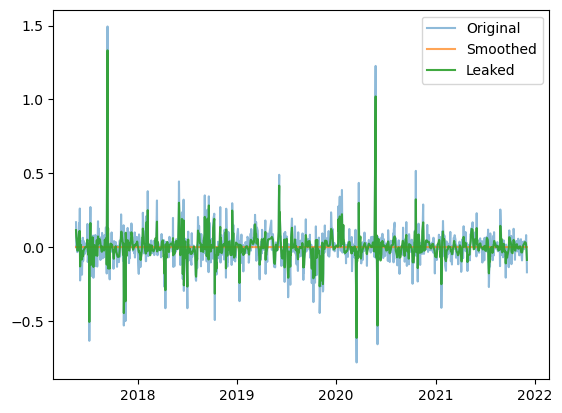

In [83]:


@jit(nopython=True)
def threshold_coefficients(coeffs, threshold):
    """
    Apply soft thresholding to wavelet coefficients.
    """
    return np.sign(coeffs) * np.maximum(np.abs(coeffs) - threshold, 0)

@jit(nopython=True)
def dwt_causal_numba(data, low_pass, high_pass, level):
    """
    Perform DWT causally using Numba.
    Args:
        data (np.ndarray): Input data (up to time t).
        low_pass (np.ndarray): Low-pass filter coefficients.
        high_pass (np.ndarray): High-pass filter coefficients.
        level (int): Number of decomposition levels.
    Returns:
        list: Coefficients [approximation, detail_1, detail_2, ...].
    """
    n = len(data)
    coeffs = []
    current = data
    for _ in range(level):
        approx = np.zeros((n + len(low_pass) - 1) // 2)
        detail = np.zeros((n + len(high_pass) - 1) // 2)
        for i in range(0, n, 2):
            for k in range(len(low_pass)):
                if i + k < n:
                    approx[i // 2] += current[i + k] * low_pass[k]
                    detail[i // 2] += current[i + k] * high_pass[k]
        coeffs.append(detail)
        current = approx
        n = len(current)
    coeffs.append(current)
    return coeffs[::-1]

@jit(nopython=True)
def idwt_causal_numba(coeffs, low_pass, high_pass):
    """
    Perform inverse DWT causally using Numba.
    """
    current = coeffs[0]
    for details in coeffs[1:]:
        n = len(current)
        upsampled_approx = np.zeros(n * 2)
        upsampled_approx[::2] = current
        upsampled_detail = np.zeros(len(details) * 2)
        upsampled_detail[::2] = details

        approx = np.zeros(len(upsampled_approx) + len(low_pass) - 1)
        detail = np.zeros(len(upsampled_detail) + len(high_pass) - 1)

        for i in range(len(upsampled_approx)):
            for k in range(len(low_pass)):
                if i + k < len(approx):
                    approx[i + k] += upsampled_approx[i] * low_pass[k]

        for i in range(len(upsampled_detail)):
            for k in range(len(high_pass)):
                if i + k < len(detail):
                    detail[i + k] += upsampled_detail[i] * high_pass[k]

        # Combine approximation and detail
        min_length = min(len(approx), len(detail))
        current = approx[:min_length] + detail[:min_length]
    return current

@jit(nopython=True)
def wavelet_smoothing_causal_numba(signal, low_pass, high_pass, level, threshold):
    """
    Perform wavelet smoothing causally using Numba.
    """
    smoothed_signal = np.zeros(len(signal))
    for t in range(1, len(signal) + 1):
        historical_data = signal[:t]
        coeffs = dwt_causal_numba(historical_data, low_pass, high_pass, level)
        thresholded_coeffs = [coeffs[0]]
        for detail in coeffs[1:]:
            thresholded_coeffs.append(threshold_coefficients(detail, threshold))
        smoothed_historical = idwt_causal_numba(thresholded_coeffs, low_pass, high_pass)
        smoothed_signal[t - 1] = smoothed_historical[-1]
    return smoothed_signal



Xt = df.loc[6407, 'delta_beta_diff1'].dropna()  # Replace with your data
wave = 'db6'
wavelet = pywt.Wavelet(wave)
low_pass = np.array(wavelet.dec_lo)
high_pass = np.array(wavelet.dec_hi)
level = 2
threshold = 0.1

Yt = wavelet_smoothing_causal_numba(Xt.values, low_pass, high_pass, level=level, threshold=threshold)
Yt_leaked = wavelet_smooth(Xt, wave, level, threshold)

fig, ax = plt.subplots()
ax.plot(Xt, label="Original", alpha = 0.5)
ax.plot(Xt.index, Yt, label="Smoothed", alpha=0.7)
ax.plot(Yt_leaked, label="Leaked", alpha=0.9)
ax.legend()
plt.show()


/home/rakin/miniconda3/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


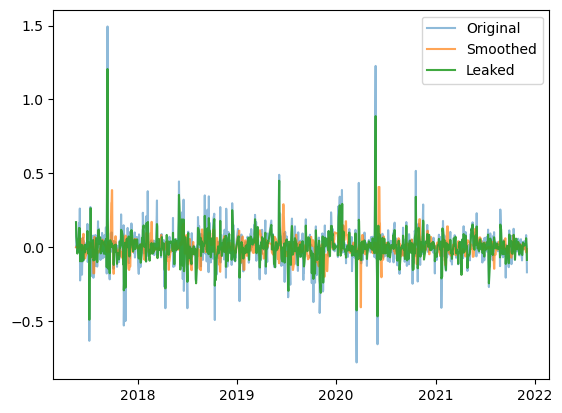

In [110]:
import numpy as np
from numba import jit

@jit(nopython=True)
def convolve(signal, kernel):
    """
    Perform convolution between a signal and a kernel.
    Args:
        signal (np.ndarray): Input signal.
        kernel (np.ndarray): Convolution kernel (filter coefficients).
    Returns:
        np.ndarray: Result of the convolution.
    """
    n = len(signal)
    m = len(kernel)
    result = np.zeros(n + m - 1)
    for i in range(n):
        for j in range(m):
            result[i + j] += signal[i] * kernel[j]
    return result

@jit(nopython=True)
def threshold_coefficients(coeffs, threshold):
    """
    Apply soft thresholding to wavelet coefficients.
    Args:
        coeffs (np.ndarray): Input coefficients.
        threshold (float): Threshold value.
    Returns:
        np.ndarray: Thresholded coefficients.
    """
    return np.sign(coeffs) * np.maximum(np.abs(coeffs) - threshold, 0)

@jit(nopython=True)
def dwt_causal(signal, low_pass, high_pass):
    """
    Perform one-level DWT causally up to the current length of the signal.
    Args:
        signal (np.ndarray): Input signal.
        low_pass (np.ndarray): Low-pass filter.
        high_pass (np.ndarray): High-pass filter.
    Returns:
        tuple: Approximation coefficients (cA) and detail coefficients (cD).
    """
    approx = convolve(signal, low_pass)[::2]  # Downsample
    detail = convolve(signal, high_pass)[::2]  # Downsample
    return approx, detail

@jit(nopython=True)
def idwt_causal(approx, detail, low_pass, high_pass):
    """
    Perform one-level inverse DWT causally from approximation and detail coefficients.
    Args:
        approx (np.ndarray): Approximation coefficients (cA).
        detail (np.ndarray): Detail coefficients (cD).
        low_pass (np.ndarray): Reconstruction low-pass filter.
        high_pass (np.ndarray): Reconstruction high-pass filter.
    Returns:
        np.ndarray: Reconstructed signal.
    """
    # Upsample
    upsampled_approx = np.zeros(len(approx) * 2)
    upsampled_approx[::2] = approx
    upsampled_detail = np.zeros(len(detail) * 2)
    upsampled_detail[::2] = detail

    # Convolve with reconstruction filters
    approx_reconstructed = convolve(upsampled_approx, low_pass[::-1])
    detail_reconstructed = convolve(upsampled_detail, high_pass[::-1])

    # Combine and return the reconstructed signal
    min_length = min(len(approx_reconstructed), len(detail_reconstructed))
    return approx_reconstructed[:min_length] + detail_reconstructed[:min_length]

@jit(nopython=True)
def wavelet_smoothing_causal_numba(signal, low_pass, high_pass, level, threshold):
    """
    Perform wavelet smoothing causally with Numba optimization.
    Args:
        signal (np.ndarray): Input time series signal.
        low_pass (np.ndarray): Low-pass filter.
        high_pass (np.ndarray): High-pass filter.
        level (int): Number of decomposition levels.
        threshold (float): Threshold for noise reduction.
    Returns:
        np.ndarray: Smoothed signal.
    """
    n = len(signal)
    smoothed_signal = np.zeros(n)

    for t in range(1, n + 1):
        historical_data = signal[:t]  # Use data up to time t
        coeffs = []  # Store coefficients for reconstruction

        # Decomposition step
        current_signal = historical_data
        for _ in range(level):
            approx, detail = dwt_causal(current_signal, low_pass, high_pass)
            coeffs.append(threshold_coefficients(detail, threshold))  # Threshold detail
            current_signal = approx
        coeffs.append(current_signal)  # Final approximation

        # Reconstruction step
        current_signal = coeffs.pop()  # Start with final approximation
        while coeffs:
            detail = coeffs.pop()
            current_signal = idwt_causal(current_signal, detail, low_pass, high_pass)

        # Assign the last reconstructed value as the smoothed value at time t
        smoothed_signal[t - 1] = current_signal[-1]

    return smoothed_signal


Xt = df.loc[6407, 'delta_beta_diff1'].dropna()  # Replace with your data
wave = 'db6'
wavelet = pywt.Wavelet(wave)
low_pass = np.array(wavelet.dec_lo)
high_pass = np.array(wavelet.dec_hi)
level = 2
threshold = 0.3

Yt = wavelet_smoothing_causal_numba(Xt.values, low_pass, high_pass, level=level, threshold=threshold)
Yt_leaked = wavelet_smoothing_causal(Xt, wave, level, threshold)

fig, ax = plt.subplots()
ax.plot(Xt, label="Original", alpha = 0.5)
ax.plot(Xt.index, Yt, label="Smoothed", alpha=0.7)
ax.plot(Yt_leaked, label="Leaked", alpha=0.9)
ax.legend()
plt.show()


In [ ]:
import pywt

In [ ]:
# run time testing of `convolve`

# import numpy as np
# from numba import jit
# import time

# @jit(nopython=True)
# def convolve(signal, kernel):
#     n = len(signal)
#     m = len(kernel)
#     result = np.zeros(n + m - 1)
#     for i in range(n):
#         for j in range(m):
#             result[i + j] += signal[i] * kernel[j]
#     return result

# @jit(nopython=True)
# def inline_convolve(signal, kernel):
#     n = len(signal)
#     m = len(kernel)
#     result = np.zeros(n + m - 1)
#     for i in range(n):
#         for j in range(m):
#             result[i + j] += signal[i] * kernel[j]
#     return result

# @jit(nopython=True)
# def test_separate(signal, kernel):
#     return convolve(signal, kernel)

# @jit(nopython=True)
# def test_inline(signal, kernel):
#     n = len(signal)
#     m = len(kernel)
#     result = np.zeros(n + m - 1)
#     for i in range(n):
#         for j in range(m):
#             result[i + j] += signal[i] * kernel[j]
#     return result

# # Example signal and kernel
# signal = np.random.randn(1000000)
# kernel = np.random.randn(10000)

# # Benchmark separate function
# start = time.time()
# test_separate(signal, kernel)
# print("Separate function time:", time.time() - start)

# # Benchmark inline implementation
# start = time.time()
# test_inline(signal, kernel)
# print("Inline implementation time:", time.time() - start)


Separate function time: 91.56729578971863
Inline implementation time: 87.26682615280151


In [84]:
# import time
# t0 = time.time()

# df['leaked_wave'] = df.groupby('Code', group_keys=False)['delta_beta_diff1'].apply(wavelet_smooth)
# t1 = time.time(); print(t1-t0)

# df['causal_wave'] = df.groupby('Code', group_keys=False)['delta_beta_diff1'].apply(wavelet_smoothing_causal)
# t2 = time.time(); print(t2-t1)
# # Example usage
# Xt = df.loc[6407, 'delta_beta_diff1'].dropna().copy()  # Replace with your data
# wavelet = 'db6'
# level = 3
# threshold = 1e-1


# Y_t = wavelet_smoothing_causal(Xt, wavelet, level, threshold)
# Z_t = wavelet_smooth(Xt, wavelet, level, threshold)
# # Convert Y_t back to a pandas Series if needed

# sec_code = 6407
# fig, ax = plt.subplots()

# sns.lineplot(df.loc[sec_code], x='Date', y = 'delta_beta_diff1', alpha=0.3)
# sns.lineplot(df.loc[sec_code], x='Date', y = 'leaked_wave')
# sns.lineplot(df.loc[sec_code], x='Date', y = 'causal_wave')

# # ax.plot(Xt.index, Xt/Xt.max(), alpha=0.5)
# # ax.plot(Xt.index, Y_t/Y_t.max(), alpha=0.8, label='causal')
# # ax.plot(Xt.index, Z_t/Z_t.max(), alpha=0.8, label='lookahead/leaked')
# ax.legend()
# # Seems like this approach is performing wavedec and waverec for each point in the time series.
# # Might be a good idea to try and implement this in numba.


Separate function time: 0.2940053939819336
Inline implementation time: 0.13811612129211426
